In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 99% 537M/545M [00:05<00:00, 81.8MB/s]
100% 545M/545M [00:05<00:00, 102MB/s] 


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image as mping
import matplotlib.pyplot as plt
import random

In [5]:
df = pd.read_csv("/content/cat_dog.csv")
df.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


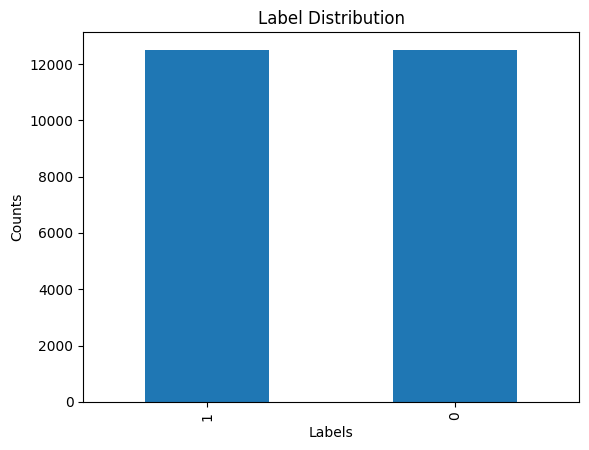

In [6]:
df['labels'].value_counts().plot.bar(title="Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.show()

(433, 496, 3)


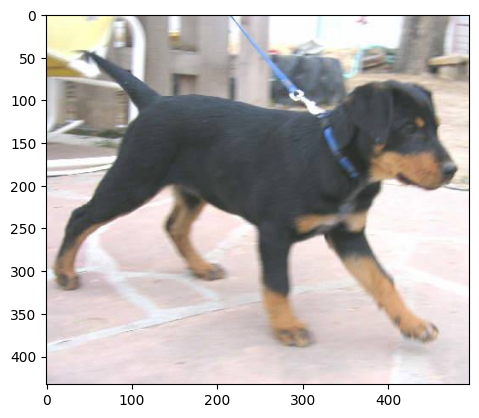

In [7]:
img=np.array(mping.imread("/content/cat_dog/dog.10500.jpg"))
# img.setflags(write=1)
print(img.shape)
plt.imshow(img)
plt.show()

In [8]:
import os
import shutil

# Create directories for cats and dogs
os.makedirs('cat_dog/cats', exist_ok=True)
os.makedirs('cat_dog/dogs', exist_ok=True)

# Move images based on labels
for index, row in df.iterrows():
    src = os.path.join('cat_dog', row['image'])

    if row['labels'] == 0:
        dest = os.path.join('cat_dog/cats', row['image'])
    else:
        dest = os.path.join('cat_dog/dogs', row['image'])

    if os.path.exists(src):  # Ensure the source file exists
        shutil.move(src, dest)

print("Images organized successfully!")

Images organized successfully!


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Split dataset for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data
train_generator = datagen.flow_from_directory(
    'cat_dog',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # 80% for training
)

# Validation data
validation_generator = datagen.flow_from_directory(
    'cat_dog',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 20% for validation
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [11]:
print(f"Training samples count: {train_generator.samples}")
print(f"Validation samples count: {validation_generator.samples}")

Training samples count: 20000
Validation samples count: 5000


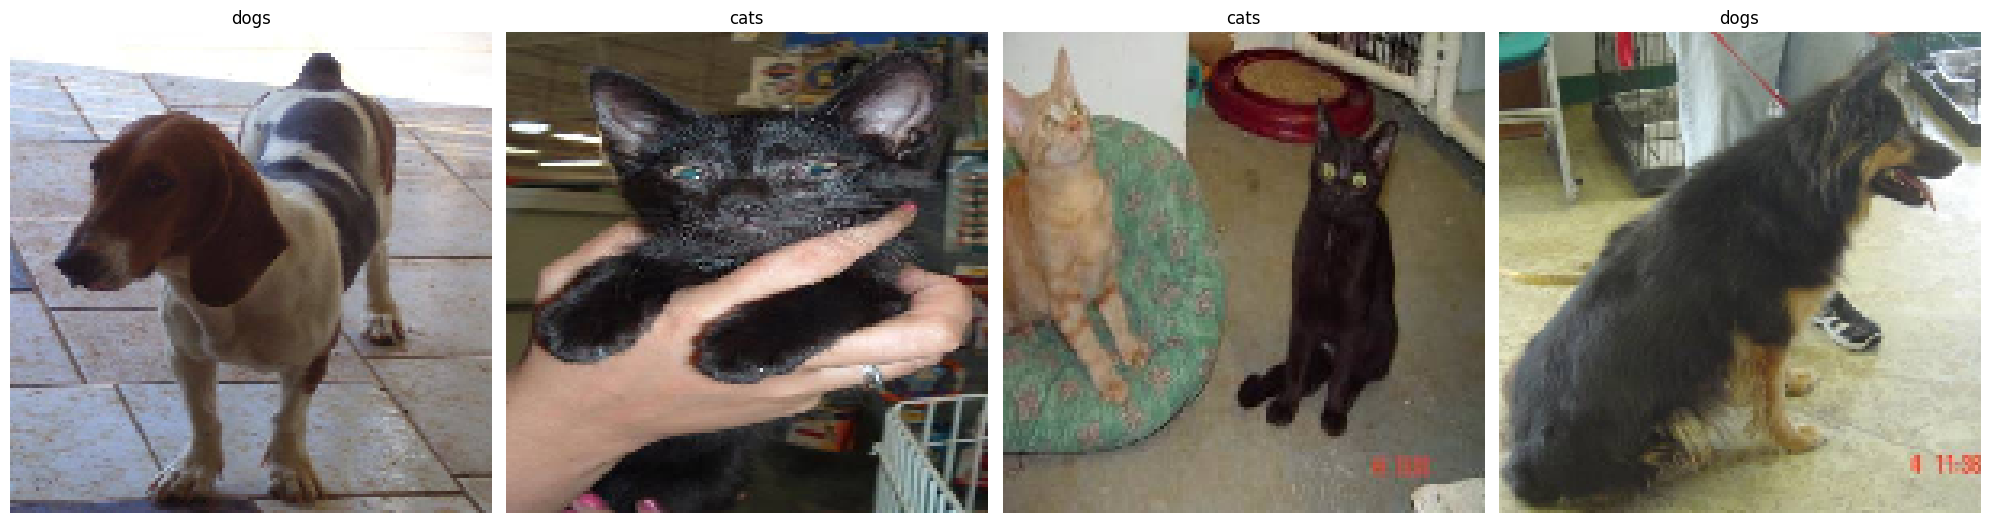

In [12]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Creating a CNN model
model = Sequential()

# First Conv Block - Changed input_shape to (150, 150, 3)
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Conv Block
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Conv Block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 9, 9, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 369,969 (1.41 MB)

 Trainable params: 369,473 (1.41 MB)

 Non-trainable params: 496 (1.94 KB)

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint

# Add ModelCheckpoint to save the best weights, ensuring the filepath ends with '.keras'
checkpoint = ModelCheckpoint('best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model with the checkpoint
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[checkpoint]  # Just include the callback here
)

# Load the best weights after training
model.load_weights('best_weights.keras')  # Also update the loading path

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - accuracy: 0.6181 - loss: 1.9485 - val_accuracy: 0.6872 - val_loss: 0.9546
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.7407 - loss: 0.8239 - val_accuracy: 0.7510 - val_loss: 0.6855
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.8001 - loss: 0.6300 - val_accuracy: 0.7040 - val_loss: 0.7458
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.8389 - loss: 0.5760 - val_accuracy: 0.7948 - val_loss: 0.6566
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8607 - loss: 0.5477 - val_accuracy: 0.8528 - val_loss: 0.5532
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.8732 - loss: 0.5092 - val_accuracy: 0.8200 - val_loss: 0.5989
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.8856 - loss: 0.4842 - val_accuracy: 0.8210 - val_loss: 0.6025
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8923 - loss: 0.4725 - val_accurac

In [17]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8992 - loss: 0.4065
Test Accuracy: 89.84%
Test Loss: 0.4097


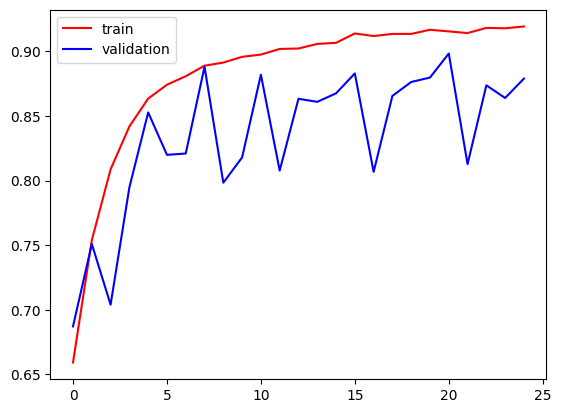

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color ='red',label ='train')
plt.plot(history.history['val_accuracy'],color ='blue',label ='validation')
plt.legend()
plt.show()

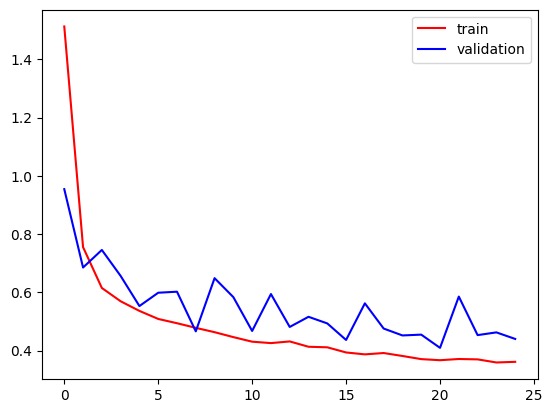

In [32]:

plt.plot(history.history['loss'],color ='red',label ='train')
plt.plot(history.history['val_loss'],color ='blue',label ='validation')
plt.legend()
plt.show()

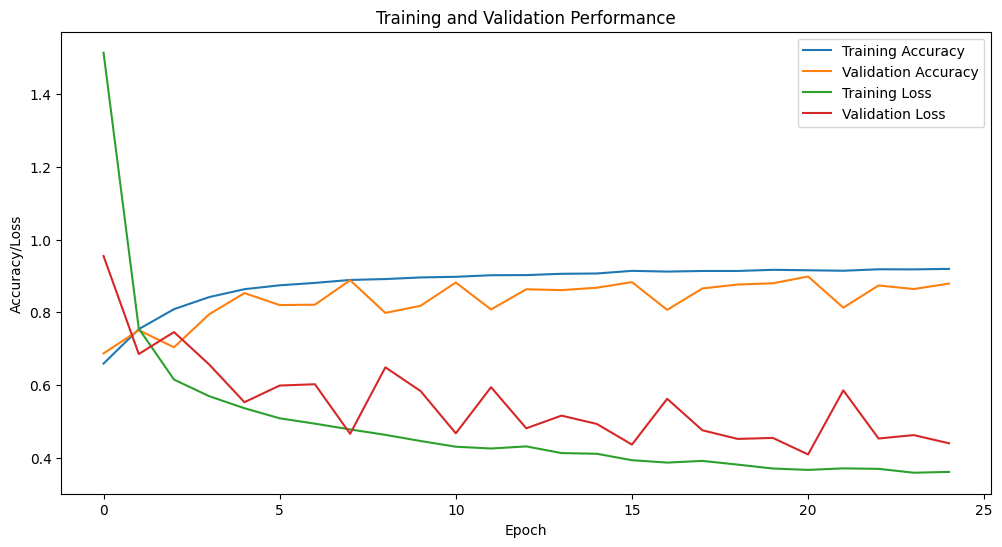

In [20]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

In [42]:
import cv2

In [43]:
test_img1 = cv2.imread('/content/cat_dog/cats/cat.1000.jpg')
test_img2 = cv2.imread('/content/cat_dog/dogs/dog.1005.jpg')

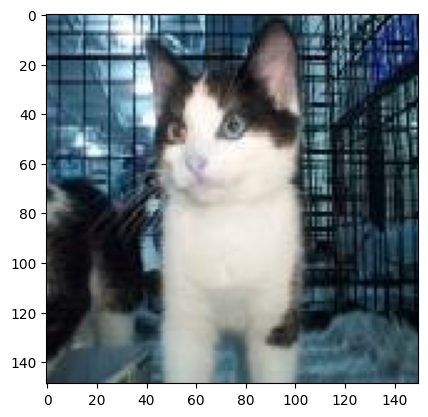

In [44]:
plt.imshow(test_img1)

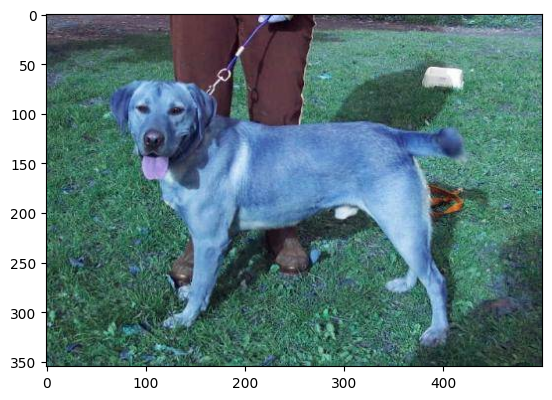

In [45]:
plt.imshow(test_img2)

In [46]:
test_img1.shape
test_img2.shape

(355, 500, 3)

In [47]:
test_img1 = cv2.resize(test_img1,(150,150))
test_img2 = cv2.resize(test_img2,(150,150))

test_input1 = test_img1.reshape((-1,150,150,3))
test_input2 = test_img2.reshape((-1,150,150,3))

In [48]:
model.predict(test_input1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.]], dtype=float32)

In [49]:
model.predict(test_input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[1.]], dtype=float32)